In [54]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 基础函数

In [258]:
def load_data_set(filename):
    """
    读取数据
    :param filename: 文件名
    :return:
    """
    data_mat = []; label_mat = []
    fr = open(filename)
    for line in fr.readlines():
        line_attr = line.strip().split('\t')
        data_mat.append([float(line_attr[0]), float(line_attr[1])])
        label_mat.append(float(line_attr[2]))
    return data_mat, label_mat


def select_j_rand(i, m):
    """
    随机选择一个alpha
    :param i: 当前alpha下表
    :param m: alpha总数目
    :return:
    """
    j = i
    while j == i:
        j = int(np.random.uniform(0, m))
    return j


def clip_alpha(aj, h, l):
    """
    调整大于h或者小于l的alpha的取值
    :param aj: 当前alpha取值
    :param h: 上限
    :param l: 下限
    :return:
    """
    if aj > h:
        aj = h
    if l > aj:
        aj = l
    return aj

def calc_w(alphas, data_arr, class_labels):
    """
    根据alpha求w
    :param alphas: 
    :param data_arr: 
    :param class_labels: 
    :return: 
    """
    x = np.mat(data_arr)
    label_mat = np.mat(class_labels).transpose()
    m,n = np.shape(x)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i] * label_mat[i], x[i,:].T)
    return w

def plot_svm(weights, start_x=2.0, end_x=6.0):
    """
    绘图
    """
    data_mat, label_mat = load_data_set('data/svm/test_set.txt')
    data_arr = np.array(data_mat)
    n = np.shape(data_arr)[0]  # 样本数量

    # 绘制样本点
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    xcord3 = []; ycord3 = []
    for i in range(n):
        if int(label_mat[i]) == 1:
            xcord1.append(data_arr[i, 0]); ycord1.append(data_arr[i, 1])
            if alphas[i] > 0.0:
                xcord3.append(data_arr[i, 0]); ycord3.append(data_arr[i, 1])
        else:
            xcord2.append(data_arr[i, 0]); ycord2.append(data_arr[i, 1])
            if alphas[i] > 0.0:
                xcord3.append(data_arr[i, 0]); ycord3.append(data_arr[i, 1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    ax.scatter(xcord3, ycord3, s=200, facecolors='None')

    # 绘制超平面
    x = np.arange(start_x, end_x, 0.1)
    y = (-weights[0] - weights[1] * x) / weights[2]
    ax.plot(x, y)

    plt.xlabel('X1'); plt.ylabel('X2')
    plt.show()

## 简化版SMO算法

In [259]:
def smo_simple(data_mat_in, class_labels, c, toler, max_iter):
    """
    SMO的简化版本

    :param data_mat_in: 数据集
    :param class_labels: 类别标签
    :param c: 常数C
    :param toler: 容错率
    :param max_iter: 最大循环次数
    :return:
    """
    data_matrix = np.mat(data_mat_in)  # numpy矩阵
    label_mat = np.mat(class_labels).transpose()  # numpy矩阵 转置，得到一个列向量
    m,n = np.shape(data_matrix)
    b = 0
    alphas = np.mat(np.zeros((m, 1)))
    iter = 0

    while iter < max_iter:  # 没有任何alpha改变的情况下遍历数据集的次数
        alpha_pairs_changed = 0
        for i in range(m):
            # 用目前参数预测样本i的类别
            f_xi = float(np.multiply(alphas, label_mat).T * (data_matrix * data_matrix[i,:].T)) + b
            # 预测误差
            e_i = f_xi - float(label_mat[i])

            # 误差较大（且alpha不在边界上）则进行优化
            if ((label_mat[i] * e_i < - toler) and (alphas[i] < c)) or ((label_mat[i] * e_i > toler) and (alphas[i] > 0)):
                # 随机选择第二个alpha
                j = select_j_rand(i, m)
                # 用目前参数预测样本j的类别
                f_xj = float(np.multiply(alphas, label_mat).T * (data_matrix * data_matrix[j,:].T)) + b
                # 预测误差
                e_j = f_xj - float(label_mat[j])

                # 备份旧的alpha值
                alpha_i_old = alphas[i].copy()
                alpha_j_old = alphas[j].copy()

                # 保证alpha在0到c之间
                if label_mat[i] != label_mat[j]:
                    l = max(0, alphas[j] - alphas[i])
                    h = min(c, c + alphas[j] - alphas[i])
                else:
                    l = max(0, alphas[j] + alphas[i] - c)
                    h = min(c, alphas[j] + alphas[i])
                if l == h:
                    #print("l==h")
                    continue

                # eta是alpha[j]的最优修改量
                eta = 2.0 * data_matrix[i,:] * data_matrix[j,:].T - data_matrix[i,:] * data_matrix[i,:].T \
                      - data_matrix[j,:] * data_matrix[j,:].T
                if eta >= 0:
                    #print("eta>=0")
                    continue
                alphas[j] -= label_mat[j] * (e_i - e_j) / eta
                alphas[j] = clip_alpha(alphas[j], h, l)
                if abs(alphas[j] - alpha_j_old) < 0.00001:
                    #print("j not moving enough")
                    continue

                # 对alpha[i]进行修改，修改方向与j相反
                alphas[i] += label_mat[j] * label_mat[i] * (alpha_j_old - alphas[j])

                # 设置常数项
                b1 = b - e_i - label_mat[i] * (alphas[i] - alpha_i_old) * data_matrix[i,:] * data_matrix[i,:].T -\
                    label_mat[j] * (alphas[j] - alpha_j_old) * data_matrix[i,:] * data_matrix[j,:].T
                b2 = b - e_j - label_mat[i] * (alphas[i] - alpha_i_old) * data_matrix[i,:] * data_matrix[j,:].T -\
                    label_mat[j] * (alphas[j] - alpha_j_old) * data_matrix[j,:] * data_matrix[j,:].T
                if 0 < alphas[i] and c > alphas[i]:
                    b = b1
                elif 0 < alphas[j] and c > alphas[j]:
                    b = b2
                else:
                    b = (b1 + b2) / 2.0

                # 成功的改变了一对alpha
                alpha_pairs_changed += 1
                #print("iter %d i: %d, pairs changed %d" % (iter, i, alpha_pairs_changed))

        if alpha_pairs_changed == 0:
            iter += 1
        else:
            iter = 0
        #print("iteration number: %d" % iter)

    return b, alphas

### 简化版SMO算法SVM示例

[-3.84657458  0.81690005 -0.27333722]


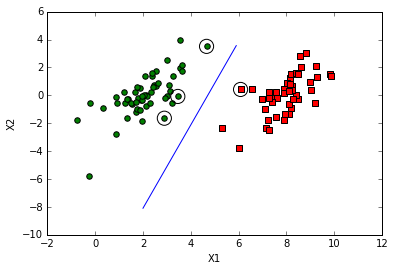

In [260]:
data_arr, label_arr = load_data_set('data/svm/test_set.txt')

b, alphas = smo_simple(data_arr, label_arr, 0.6, 0.001, 40)

sum = calc_w(alphas, data_arr, label_arr)

weights = np.zeros(3)
weights[0] = b
weights[1] = sum[0][0]
weights[2] = sum[1][0]
print(weights)

# 绘图，大圆圈表示支持向量
plot_svm(weights)

## 完整版SMO算法

In [267]:
class OptStruct:
    def __init__(self, data_mat_in, class_labels, c, toler):
        self.x = data_mat_in
        self.label_mat = class_labels
        self.c = c
        self.tol = toler
        self.m = np.shape(data_mat_in)[0]
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.e_cache = np.mat(np.zeros((self.m, 2)))  # 误差缓存


def calc_e_k(o_s, k):
    """
    计算误差
    """
    f_xk = float(np.multiply(o_s.alphas, o_s.label_mat).T * (o_s.x * o_s.x[k,:].T)) + o_s.b
    e_k = f_xk - float(o_s.label_mat[k])
    return e_k


def select_j(i, o_s, e_i):
    """
    选择第二个alpha（内循环中的alpha），每次优化中采用最大步长
    :param i:
    :param o_s:
    :param e_i:
    :return:
    """
    max_k = -1; max_delta_e = 0; e_j = 0
    o_s.e_cache[i] = [1, e_i]
    valid_e_cache_list = np.nonzero(o_s.e_cache[:,0])[0]  # 已经计算好了误差的alpha
    
    if len(valid_e_cache_list) > 1:
        # 在已经计算好了误差的alpha中选择相差最大的
        for k in valid_e_cache_list:
            if k == i:
                continue
            e_k = calc_e_k(o_s, k)
            delta_e = abs(e_i - e_k)
            if delta_e > max_delta_e:
                max_k = k; max_delta_e = delta_e; e_j = e_k
        return max_k, e_j
    else:
        # 随机选取一个
        j = select_j_rand(i, o_s.m)
        e_j = calc_e_k(o_s, j)
    return j, e_j


def update_e_k(o_s, k):
    """
    计算误差值，并存入缓存
    :param o_s:
    :param k:
    :return:
    """
    e_k = calc_e_k(o_s, k)
    o_s.e_cache[k] = [1, e_k]


def inner_l(i, o_s):
    e_i = calc_e_k(o_s, i)
    if (o_s.label_mat[i] * e_i < -o_s.tol and o_s.alphas[i] < o_s.c) or (o_s.label_mat[i] * e_i > o_s.tol and o_s.alphas[i] > 0):
        j, e_j = select_j(i, o_s, e_i)
        alpha_i_old = o_s.alphas[i].copy()
        alpha_j_old = o_s.alphas[j].copy()

        if o_s.label_mat[i] != o_s.label_mat[j]:
            l = max(0, o_s.alphas[j] - o_s.alphas[i])
            h = min(o_s.c, o_s.c + o_s.alphas[j] - o_s.alphas[i])
        else:
            l = max(0, o_s.alphas[j] + o_s.alphas[i] - o_s.c)
            h = max(o_s.c, o_s.alphas[j] + o_s.alphas[i])
        if l == h:
            #print("l==h")
            return 0

        eta = 2.0 * o_s.x[i, :] * o_s.x[j, :].T - o_s.x[i, :] * o_s.x[i, :].T - o_s.x[j, :] * o_s.x[j, :].T
        if eta >= 0:
            #print("eta>=0")
            return 0

        o_s.alphas[j] -= o_s.label_mat[j] * (e_i - e_j) / eta
        o_s.alphas[j] = clip_alpha(o_s.alphas[j], h, l)
        update_e_k(o_s, j)  # 更新误差缓存
        if abs(o_s.alphas[j] - alpha_j_old) < 0.00001:
            #print("j not moving enough")
            return 0
        o_s.alphas[i] += o_s.label_mat[j] * o_s.label_mat[i] * (alpha_j_old - o_s.alphas[j])
        update_e_k(o_s, i)  # 更新误差缓存

        b1 = o_s.b - e_i - o_s.label_mat[i] * (o_s.alphas[i] - alpha_i_old) * o_s.x[i,:] * o_s.x[i,:].T -\
            o_s.label_mat[j] * (o_s.alphas[j] - alpha_j_old) * o_s.x[i,:] * o_s.x[j,:].T
        b2 = o_s.b - e_j - o_s.label_mat[i] * (o_s.alphas[i] - alpha_i_old) * o_s.x[i,:] * o_s.x[j,:].T - \
             o_s.label_mat[j] * (o_s.alphas[j] - alpha_j_old) * o_s.x[j,:] * o_s.x[j,:].T
        if 0 < o_s.alphas[i] and o_s.c > o_s.alphas[i]:
            o_s.b = b1
        elif 0 < o_s.alphas[j] and o_s.c > o_s.alphas[j]:
            o_s.b = b2
        else:
            o_s.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0


def smo_p(data_mat_in, class_labels, c, toler, max_iter, k_tup=('lin', 0)):
    o_s = OptStruct(np.mat(data_mat_in), np.mat(class_labels).transpose(), c, toler)
    iter = 0
    entire_set = True
    alpha_pairs_changed = 0

    while iter < max_iter and (alpha_pairs_changed > 0 or entire_set):
        alpha_pairs_changed = 0
        if entire_set:
            # 遍历所有的值
            for i in range(o_s.m):
                alpha_pairs_changed += inner_l(i, o_s)
            #print("fullSet, iter: %d i:%d, pairs changed %d" % (iter, i, alpha_pairs_changed))
            iter += 1
        else:
            # 遍历非边界值
            non_bound_i_s = np.nonzero((o_s.alphas.A > 0) * (o_s.alphas.A < c))[0]
            for i in non_bound_i_s:
                alpha_pairs_changed += inner_l(i, o_s)
                #print("non-bound, iter: %d i:%d, pairs changed %d" % (iter, i, alpha_pairs_changed))
            iter += 1
        if entire_set:
            entire_set = False
        elif alpha_pairs_changed == 0:
            entire_set = True
        #print("iteration number: %d" % iter)
    return o_s.b, o_s.alphas

### 完整版SMO算法SVM示例

[-3.67412386  0.78618488 -0.25384166]


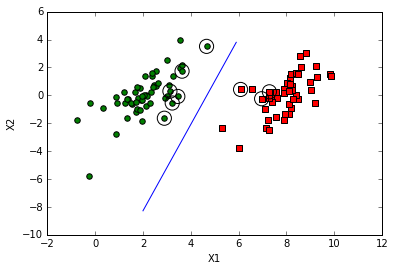

In [285]:
data_arr, label_arr = load_data_set('data/svm/test_set.txt')
b, alphas = smo_p(data_arr, label_arr, 0.6, 0.001, 40)

sum = calc_w(alphas, data_arr, label_arr)

weights = np.zeros(3)
weights[0] = b
weights[1] = sum[0][0]
weights[2] = sum[1][0]
print(weights)

plot_svm(weights, 2.0,6.0)

## 核函数

In [347]:
def kernel_trans(x, a, k_tup):
    m,n = np.shape(x)
    k = np.mat(np.zeros((m,1)))
    if k_tup[0] == 'lin':
        # 线性核函数
        k = x * a.T
    elif k_tup[0] == 'rbf':
        # 径向基核函数
        for j in range(m):
            delta_row = x[j, :] - a
            k[j] = delta_row * delta_row.T
        k = np.exp(k / (-1 * k_tup[1] ** 2))
    else:
        raise NameError('Houston We Have a Problem -- That Kernel is not recognized')
    return k

class OptStruct:
    def __init__(self, data_mat_in, class_labels, c, toler, k_tup):
        self.x = data_mat_in
        self.label_mat = class_labels
        self.c = c
        self.tol = toler
        self.m = np.shape(data_mat_in)[0]
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.e_cache = np.mat(np.zeros((self.m, 2)))  # 误差缓存

        self.k = np.mat(np.zeros((self.m, self.m)))
        for i in range(self.m):
            self.k[:, i] = kernel_trans(self.x, self.x[i, :], k_tup)


def calc_e_k(o_s, k):
    f_xk = float(np.multiply(o_s.alphas, o_s.label_mat).T * o_s.k[:, k]) + o_s.b
    e_k = f_xk - float(o_s.label_mat[k])
    return e_k


def update_e_k(o_s, k):
    """
    计算误差值，并存入缓存
    :param o_s:
    :param k:
    :return:
    """
    e_k = calc_e_k(o_s, k)
    o_s.e_cache[k] = [1, e_k]


def inner_l(i, o_s):
    e_i = calc_e_k(o_s, i)
    if (o_s.label_mat[i] * e_i < -o_s.tol and o_s.alphas[i] < o_s.c) or (o_s.label_mat[i] * e_i > o_s.tol and o_s.alphas[i] > 0):
        j, e_j = select_j(i, o_s, e_i)
        alpha_i_old = o_s.alphas[i].copy()
        alpha_j_old = o_s.alphas[j].copy()

        if o_s.label_mat[i] != o_s.label_mat[j]:
            l = max(0, o_s.alphas[j] - o_s.alphas[i])
            h = min(o_s.c, o_s.c + o_s.alphas[j] - o_s.alphas[i])
        else:
            l = max(0, o_s.alphas[j] + o_s.alphas[i] - o_s.c)
            h = max(o_s.c, o_s.alphas[j] + o_s.alphas[i])
        if l == h:
            #print("l==h")
            return 0

        eta = 2.0 * o_s.k[i,j] - o_s.k[i, i] - o_s.k[j, j]
        if eta >= 0:
            #print("eta>=0")
            return 0

        o_s.alphas[j] -= o_s.label_mat[j] * (e_i - e_j) / eta
        o_s.alphas[j] = clip_alpha(o_s.alphas[j], h, l)
        update_e_k(o_s, j)
        if abs(o_s.alphas[j] - alpha_j_old) < 0.00001:
            #print("j not moving enough")
            return 0
        o_s.alphas[i] += o_s.label_mat[j] * o_s.label_mat[i] * (alpha_j_old - o_s.alphas[j])
        update_e_k(o_s, i)

        b1 = o_s.b - e_i - o_s.label_mat[i] * (o_s.alphas[i] - alpha_i_old) * o_s.k[i, i] -\
            o_s.label_mat[j] * (o_s.alphas[j] - alpha_j_old) * o_s.k[i, j]
        b2 = o_s.b - e_j - o_s.label_mat[i] * (o_s.alphas[i] - alpha_i_old) * o_s.k[i, j] - \
             o_s.label_mat[j] * (o_s.alphas[j] - alpha_j_old) * o_s.k[j, j]
        if 0 < o_s.alphas[i] and o_s.c > o_s.alphas[i]:
            o_s.b = b1
        elif 0 < o_s.alphas[j] and o_s.c > o_s.alphas[j]:
            o_s.b = b2
        else:
            o_s.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0


def smo_p(data_mat_in, class_labels, c, toler, max_iter, k_tup=('lin', 0)):
    o_s = OptStruct(np.mat(data_mat_in), np.mat(class_labels).transpose(), c, toler, k_tup)
    iter = 0
    entire_set = True
    alpha_pairs_changed = 0

    while iter < max_iter and (alpha_pairs_changed > 0 or entire_set):
        alpha_pairs_changed = 0
        if entire_set:
            for i in range(o_s.m):
                alpha_pairs_changed += inner_l(i, o_s)
            #print("fullSet, iter: %d i:%d, pairs changed %d" % (iter, i, alpha_pairs_changed))
            iter += 1
        else:
            non_bound_i_s = np.nonzero((o_s.alphas.A > 0) * (o_s.alphas.A < c))[0]
            for i in non_bound_i_s:
                alpha_pairs_changed += inner_l(i, o_s)
                #print("non-bound, iter: %d i:%d, pairs changed %d" % (iter, i, alpha_pairs_changed))
            iter += 1
        if entire_set:
            entire_set = False
        elif alpha_pairs_changed == 0:
            entire_set = True
        #print("iteration number: %d" % iter)
    return o_s.b, o_s.alphas



def test_rbf(k1=1.3):
    data_arr, label_arr = load_data_set('data/svm/test_set_rbf.txt')
    b, alphas = smo_p(data_arr, label_arr, 200, 0.0001, 10000, ('rbf', k1))

    data_mat = np.mat(data_arr)
    label_mat = np.mat(label_arr).transpose()
    sv_ind = np.nonzero(alphas.A>0)[0]
    s_vs = data_mat[sv_ind]
    label_sv = label_mat[sv_ind]
    print("there ara %d Support Vector" % np.shape(s_vs)[0])
    m,n = np.shape(data_mat)
    error_count = 0
    for i in range(m):
        kernel_eval = kernel_trans(s_vs, data_mat[i, :], ('rbf', k1))
        predict = kernel_eval.T * np.multiply(label_sv, alphas[sv_ind]) + b
        if np.sign(predict) != np.sign(label_arr[i]):
            error_count += 1
    print("the training error rate is: %f" % (float(error_count) / m))

    data_arr, label_arr = load_data_set('data/svm/test_set_rbf2.txt')
    error_count = 0
    data_mat = np.mat(data_arr)
    label_mat = np.mat(label_arr).transpose()
    m, n = np.shape(data_mat)
    for i in range(m):
        kernel_eval = kernel_trans(s_vs, data_mat[i, :], ('rbf', k1))
        predict = kernel_eval.T * np.multiply(label_sv, alphas[sv_ind]) + b
        if np.sign(predict) != np.sign(label_arr[i]):
            error_count += 1
    print("the test error rate is: %f" % (float(error_count) / m))
    
test_rbf(0.3)

there ara 24 Support Vector
the training error rate is: 0.000000
the test error rate is: 0.050000
